In [1]:
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras import Sequential
from keras.layers import Input, Conv2D, Flatten, Dense, MaxPool2D

# Define Image to Spectrum Class

In [2]:
class SpectralConverter:
    def __init__(self, img_shape: Tuple[int, int]):
        self.img_shape_x = img_shape[0]
        self.img_shape_y = img_shape[1]
        
    def img_to_freq(self, img: np.ndarray, border_shape: Tuple[int, int] = (0, 0)):
        border_x = border_shape[0]
        border_y = border_shape[1]
        
        # Fourier Transform
        f_transform = np.fft.fft2(img)
        f_shift = np.fft.fftshift(f_transform)
        
        # Crop Image
        f_shift_cropped = f_shift[border_y:img.shape[0] - border_y, border_x:img.shape[1] - border_x]
        
        return f_shift_cropped
    
    def freq_to_img(self, freq: np.ndarray):
        img_center_x = self.img_shape_x // 2
        img_center_y = self.img_shape_y // 2
        
        freq_center_x = freq.shape[1] // 2
        freq_center_y = freq.shape[0] // 2
        
        f_shift_cropped = np.zeros((self.img_shape_y, self.img_shape_x), dtype=complex)
        
        f_shift_cropped[img_center_y - freq_center_y:img_center_y + freq_center_y,img_center_x - freq_center_x:img_center_x + freq_center_x] = freq
        
        f_ishift = np.fft.ifftshift(f_shift_cropped)
        f_itransform = np.fft.ifft2(f_ishift)
        
        return np.abs(f_itransform)

# Data Preprocessing

## Input

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
converter = SpectralConverter(x_train[0].shape)
border_shape = (11, 11)
x_train_freq = [converter.img_to_freq(img, border_shape) for img in x_train]
x_test_freq = [converter.img_to_freq(img, border_shape) for img in x_test]

In [5]:
x_train_log = np.log1p(np.abs(x_train_freq))
x_test_log = np.log1p(np.abs(x_test_freq))

In [6]:
x_train_scaled = (x_train_log - x_train_log.min()) / (x_train_log.max() - x_train_log.min()) - 0.5
x_test_scaled = (x_test_log - x_train_log.min()) / (x_train_log.max() - x_train_log.min()) - 0.5

In [7]:
x_train_scaled_flattened = x_train_scaled.reshape((-1, (x_train[0].shape[0] - 2 * border_shape[0]) * (x_train[0].shape[1] - 2 * border_shape[1])))
x_test_scaled_flattened = x_test_scaled.reshape((-1, (x_train[0].shape[0] - 2 * border_shape[0]) * (x_train[0].shape[1] - 2 * border_shape[1])))

## Output

In [8]:
ohe = OneHotEncoder(sparse_output=False)
y_train_ohe = ohe.fit_transform(y_train.reshape(-1, 1))
y_test_ohe = ohe.fit_transform(y_test.reshape(-1, 1))

# KNeighborsClassifier

In [259]:
k_neighbors_clf = KNeighborsClassifier(n_neighbors=5)
k_neighbors_clf.fit(x_train_scaled_flattened, y_train)
accuracy = k_neighbors_clf.score(x_test_scaled_flattened, y_test)

print(f'Accuracy: {accuracy}')

Accuracy: 0.8737


# LogisticRegression

In [258]:
logistic_reg_clf = LogisticRegression(max_iter=400)
logistic_reg_clf.fit(x_train_scaled_flattened, y_train)
accuracy = logistic_reg_clf.score(x_test_scaled_flattened, y_test)

print(f'Accuracy: {accuracy}')

Accuracy: 0.7389


# RandomForestClassifier

In [260]:
random_forest_clf = RandomForestClassifier()
random_forest_clf.fit(x_train_scaled_flattened, y_train)
accuracy = random_forest_clf.score(x_test_scaled_flattened, y_test)

print(f'Accuracy: {accuracy}')

Accuracy: 0.8784


# Train Neural Network

In [9]:
model_seq = Sequential([
    Input(shape=(x_train_scaled.shape[1], x_train_scaled.shape[2], 1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model_seq.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history_seq = model_seq.fit(x_train_scaled, y_train_ohe, epochs=50, batch_size=50, verbose=True, validation_data=(x_test_scaled, y_test_ohe))

Epoch 1/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5100 - loss: 1.5005 - val_accuracy: 0.7085 - val_loss: 0.8613
Epoch 2/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7157 - loss: 0.8509 - val_accuracy: 0.7642 - val_loss: 0.7033
Epoch 3/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7606 - loss: 0.7170 - val_accuracy: 0.7963 - val_loss: 0.6207
Epoch 4/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7933 - loss: 0.6333 - val_accuracy: 0.8137 - val_loss: 0.5549
Epoch 5/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8070 - loss: 0.5853 - val_accuracy: 0.8193 - val_loss: 0.5542
Epoch 6/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8199 - loss: 0.5446 - val_accuracy: 0.8398 - val_loss: 0.4892
Epoch 7/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8303 - loss: 0.5120 - val_accuracy: 0.8492 - val_loss: 0.4690
Epoch 8/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8403 - loss: 0.4856 - 

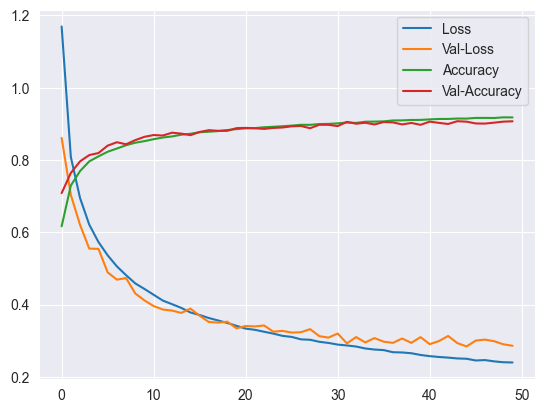

In [11]:
plt.plot(history_seq.history['loss'], label='Loss')
plt.plot(history_seq.history['val_loss'], label='Val-Loss')
plt.plot(history_seq.history['accuracy'], label='Accuracy')
plt.plot(history_seq.history['val_accuracy'], label='Val-Accuracy')
plt.legend()
plt.show()

# Train Convolutional Neural Network

In [264]:
model_conv = Sequential([
    Input(shape=(x_train_scaled.shape[1], x_train_scaled.shape[2], 1)),
    Conv2D(8, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

model_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [265]:
history_conv = model_conv.fit(x_train_scaled, y_train_ohe, epochs=50, batch_size=50, verbose=True, validation_data=(x_test_scaled, y_test_ohe))

Epoch 1/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2782 - loss: 2.0434 - val_accuracy: 0.5355 - val_loss: 1.4069
Epoch 2/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5400 - loss: 1.3552 - val_accuracy: 0.6263 - val_loss: 1.1309
Epoch 3/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6245 - loss: 1.1226 - val_accuracy: 0.6577 - val_loss: 1.0085
Epoch 4/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6585 - loss: 1.0091 - val_accuracy: 0.6970 - val_loss: 0.9204
Epoch 5/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6809 - loss: 0.9372 - val_accuracy: 0.7024 - val_loss: 0.8764
Epoch 6/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7027 - loss: 0.8856 - val_accuracy: 0.7249 - val_loss: 0.8310
Epoch 7/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7179 - loss: 0.8415 - val_accuracy: 0.7309 - val_loss: 0.7939
Epoch 8/50
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7240 - loss: 0.8219 - 

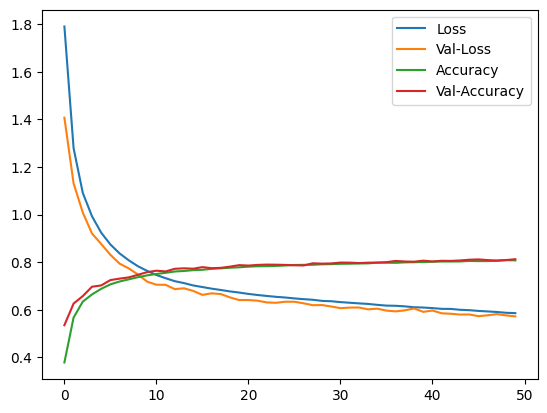

In [266]:
plt.plot(history_conv.history['loss'], label='Loss')
plt.plot(history_conv.history['val_loss'], label='Val-Loss')
plt.plot(history_conv.history['accuracy'], label='Accuracy')
plt.plot(history_conv.history['val_accuracy'], label='Val-Accuracy')
plt.legend()
plt.show()

# Confusion Matrix

In [12]:
y_pred = model_seq.predict(x_test_scaled)
cm = confusion_matrix(y_test, ohe.inverse_transform(y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


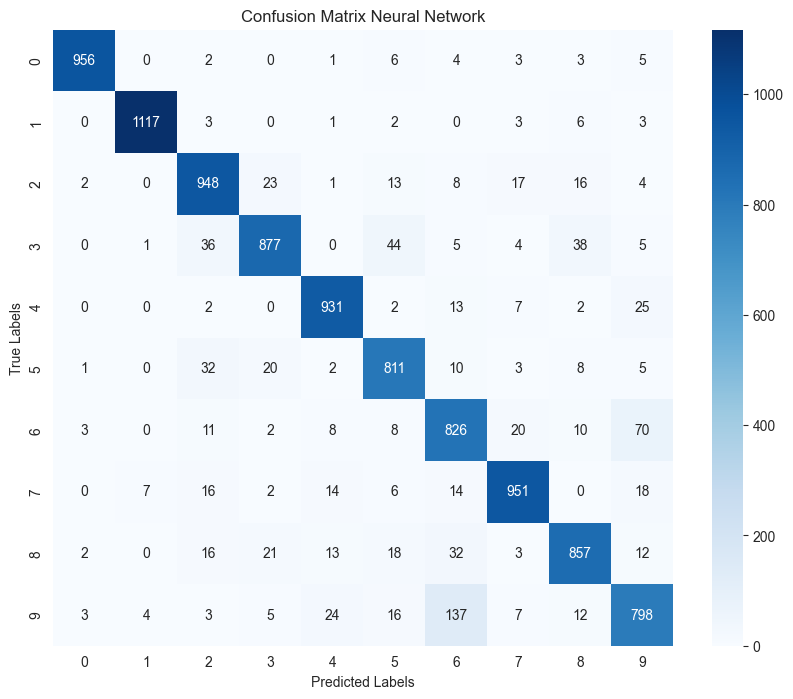

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Neural Network')
plt.show()

# Show some Examples

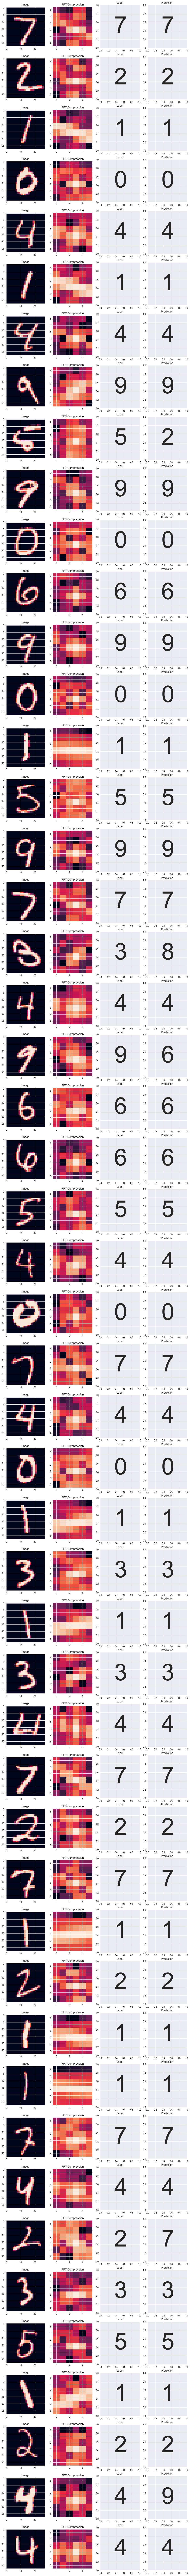

In [14]:
n_preds = 50
fig, ax = plt.subplots(n_preds, 4, figsize=(14, n_preds * 4))

for i in range(n_preds):
    img = x_test[i]
    label = y_test[i]
    nn_input = x_test_scaled[i]
    probabilities = model_seq.predict(np.expand_dims(nn_input, axis=0), verbose=False)
    pred = np.argmax(probabilities, axis=1)
    
    ax[i, 0].imshow(img)
    ax[i, 0].set_title('Image')
    
    ax[i, 1].imshow(nn_input)
    ax[i, 1].set_title('FFT-Compression')
    
    ax[i, 2].text(0.35, 0.35, label, size=100)
    ax[i, 2].set_title('Label')
    
    ax[i, 3].text(0.35, 0.35, pred[0], size=100)
    ax[i, 3].set_title('Prediction')
    
plt.show()